importing the required packages and libraries.

In [1]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv

from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization

Using TensorFlow backend


Globale Variable

In [75]:
# Path
gv_path_models= "workspace/models/"
gv_path_images = "workspace/images/original_name/"
gv_annotation_path= "workspace/annotations/original/pascal/"

SPLIT_RATIO = 0.2
BATCH_SIZE = 2
LEARNING_RATE = 0.001
EPOCH = 10
GLOBAL_CLIPNORM = 10.0

The Dataset Preparation

In [16]:
class_ids = [
"Ausbildung_Klasse" ,
"Ausbildung_Antrag_gestellt_ja" ,
"Ausbildung_Antrag_gestellt_nein" ,
"Ausbildung_Amt" ,
"Ausbildung_Foerderungsnummer" ,
"Ausbilung_Abschluss" ,
"Ausbildung_Vollzeit" ,
"Ausbildung" ,
"Ausbildung_Teilzeit" ,
"Ausbildung_Staette" ,
"Person" ,
"Person_Geburtsort" ,
"Person_maennlich" ,
"Person_Geburtsdatum" ,
"Person_weiblich",
"Person_divers",
"Person_Name",
"Person_Familienstand" ,
"Person_Vorname" ,
"Person_Geburtsname" ,
"Person_Familienstand_seit",
"Person_Stattsangehörigkeit_eigene" ,
"Person_Stattsangehörigkeit_Ehegatte" ,
"Person_Kinder",
"Wohnsitz_Strasse",
"Wohnsitz_Land",
"Wohnsitz_Postleitzahl",
"Wohnsitz",
"Wohnsitz_Hausnummer",
"Wohnsitz_Adresszusatz",
"Wohnsitz_Ort",
"Wohnsitz_waehrend_Ausbildung" ,
"Wohnsitz_waehrend_Ausbildung_Strasse",
"Wohnsitz_waehrend_Ausbildung_Hausnummer",
"Wohnsitz_waehrend_Ausbildung_Land",
"Wohnsitz_waehrend_Ausbildung_Ort",
"Wohnsitz_waehrend_Ausbildung_elternwohnung_nein",
"Wohnsitz_waehrend_Ausbildung_Adresszusatz",
"Wohnsitz_waehrend_Ausbildung_Postleitzahl",
"Wohnsitz_waehrend_Ausbildung_elternmiete",
"Wohnsitz_waehrend_Ausbildung_elternwohnung_ja",
"Wohnsitz_waehrend_Ausbildung_elternmiete_nein"
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))
 


In [35]:
# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(gv_annotation_path, file_name)
        for file_name in os.listdir(gv_annotation_path)
        if file_name.endswith(".xml")
    ]
)
 
# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(gv_path_images, file_name)
        for file_name in os.listdir(gv_path_images)
        if file_name.endswith(".jpg")
    ]
)

parsing the XML annotation files

In [36]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    print(xml_file)
    print(tree)
    print(root)
    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)
 
    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)
 
        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])
 
    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids
 
 


In [37]:
image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/17 [00:00<?, ?it/s]

workspace/annotations/original/pascal/IMG_20231124_140045.xml
<Element 'annotation' at 0x000001D401EC34C0>
workspace/annotations/original/pascal/IMG_20231124_140206.xml
<Element 'annotation' at 0x000001D401D36840>
workspace/annotations/original/pascal/IMG_20231124_140241.xml
<Element 'annotation' at 0x000001D401D522F0>
workspace/annotations/original/pascal/IMG_20231124_140334.xml
<Element 'annotation' at 0x000001D401D34630>
workspace/annotations/original/pascal/MVIMG_20231124_140120.xml
<Element 'annotation' at 0x000001D401D51E40>
workspace/annotations/original/pascal/scan_0001.xml
<Element 'annotation' at 0x000001D401D365C0>
workspace/annotations/original/pascal/scan_0002.xml
<Element 'annotation' at 0x000001D401D51E40>
workspace/annotations/original/pascal/scan_0003.xml
<Element 'annotation' at 0x000001D401D34310>
workspace/annotations/original/pascal/scan_0004.xml
<Element 'annotation' at 0x000001D401D51E40>
workspace/annotations/original/pascal/scan_0005.xml
<Element 'annotation' a

In [38]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)
 
data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [39]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [41]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image
 
def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [42]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(1.0, 1.0),
            bounding_box_format="xyxy",
        ),
    ]
)

In [68]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 8)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [69]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(1.0, 1.0),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 8)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)



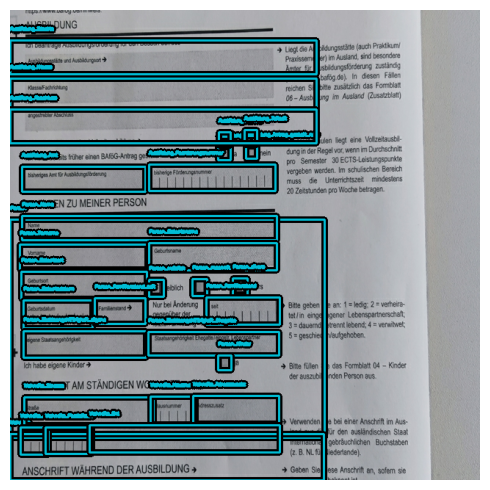

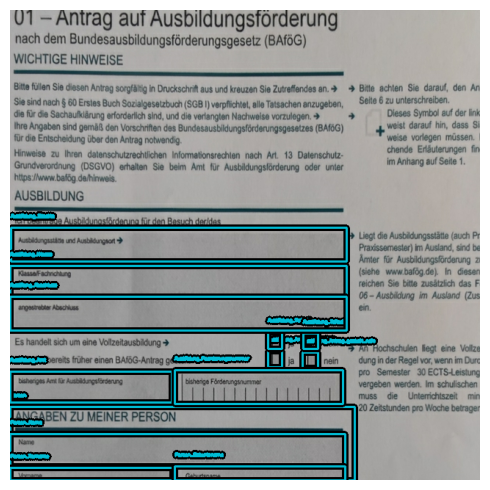

In [70]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.2,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )
 
 
visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1
)
 
visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1
)

In [71]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]
 
 
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
 
val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [72]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
     "yolo_v8_l_backbone_coco",
    # "yolo_v8_m_backbone"
     load_weights=True #It is important to set the load_weights = True, else 
                        # the COCO pretrained weights will not get loaded into the backbone
)
 
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping), #the number of object classes
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=3,
)
 
yolo.summary()

Model: "yolov8_detector_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model_1 (Functional)        {'P3': (None, None, None,    1983174   ['input_4[0][0]']             
                             256),                        4                                       
                              'P4': (None, None, None,                                            
                             512),                                                                
                              'P5': (None, None, None,                                            
                             512)}                                                

In [73]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM, #This ensures that gradients, which influence the model’s parameter updates, 
                                    # don’t become exceedingly large and destabilize training.
)
 
yolo.compile(
    optimizer=optimizer, 
    classification_loss="binary_crossentropy", #calculates the discrepancy between anticipated class probabilities and actual class probabilities
    box_loss="ciou" # box_loss -> measure the difference between the predicted bounding boxes and the ground truth
                    # he Complete IoU (CIoU) metric is used, which not only measures the overlap between predicted and ground truth bounding 
                    # boxes but also considers the difference in aspect ratio, center distance, and box size
)

In [ ]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )
 
        self.save_path = save_path
        self.best_map = -1.0
 
    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)
 
        metrics = self.metrics.result(force=True)
        logs.update(metrics)
 
        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves
 
        return logs

In [52]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs_yolov8large")

In [36]:
print(tensorboard_callback)

<_PrefetchDataset element_spec=(TensorSpec(shape=(8, 640, 640, 3), dtype=tf.float32, name=None), {'classes': RaggedTensorSpec(TensorShape([8, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([8, None, None]), tf.float32, 1, tf.int64)})>


In [74]:
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH
    # callbacks=[
    #      EvaluateCOCOMetricsCallback(val_ds, "model_yolov8large.h5"),
    #     tensorboard_callback
    # ]
)

Epoch 1/10
7/7 [==============================] - 222s 21s/step - loss: 78.1497 - box_loss: 5.1462 - class_loss: 73.0035 - val_loss: 63.0647 - val_box_loss: 5.2736 - val_class_loss: 57.7911
Epoch 2/10
7/7 [==============================] - 127s 18s/step - loss: 84.1503 - box_loss: 4.9792 - class_loss: 79.1711 - val_loss: 62.7219 - val_box_loss: 5.1710 - val_class_loss: 57.5509
Epoch 3/10
7/7 [==============================] - 134s 19s/step - loss: 97.1001 - box_loss: 4.8535 - class_loss: 92.2466 - val_loss: 76.1840 - val_box_loss: 5.1955 - val_class_loss: 70.9885
Epoch 4/10
7/7 [==============================] - 120s 17s/step - loss: 50.9496 - box_loss: 3.9892 - class_loss: 46.9603 - val_loss: 83.8597 - val_box_loss: 5.1409 - val_class_loss: 78.7188
Epoch 5/10
7/7 [==============================] - 166s 25s/step - loss: 53.2098 - box_loss: 3.2251 - class_loss: 49.9847 - val_loss: 44.1568 - val_box_loss: 4.8789 - val_class_loss: 39.2779
Epoch 6/10
7/7 [==============================] - 

In [122]:
from keras.preprocessing import image as keras_image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [63]:
import numpy as np

In [61]:
from keras.preprocessing import image as keras_image

1/1 [==============================] - 2s 2s/step
<tf.RaggedTensor [[[569.86237, 22.31337, 681.4287, 162.78983],
  [570.0687, 215.06494, 681.3874, 353.51404],
  [561.0132, 359.82904, 675.385, 498.86276],
  [561.4101, 301.51868, 675.1932, 443.7541],
  [570.3021, 288.40247, 682.1347, 423.47394],
  [551.63245, 316.14932, 665.78754, 459.20294],
  [17.991764, 167.82925, 130.7955, 309.1892],
  [570.0482, 343.0171, 682.15063, 481.81815],
  [-28.520264, 226.58655, 81.292366, 356.80243],
  [570.08813, 247.58987, 681.7984, 384.6064],
  [105.33563, 166.72052, 219.1712, 306.74103],
  [570.1209, 89.31122, 682.1595, 225.01955],
  [-15.1806755, 421.23837, 99.210266, 544.55743],
  [513.38043, 358.73474, 625.9023, 499.30234],
  [-22.965233, 165.56314, 89.71246, 309.7347],
  [-28.943771, 319.51837, 80.27982, 454.2614],
  [570.291, 191.04868, 681.6937, 328.9694],
  [9.026913, 332.72763, 122.2856, 472.09268],
  [65.945946, 167.971, 179.31425, 307.5085],
  [529.5468, 301.4909, 643.6221, 444.09137],
  [-46.

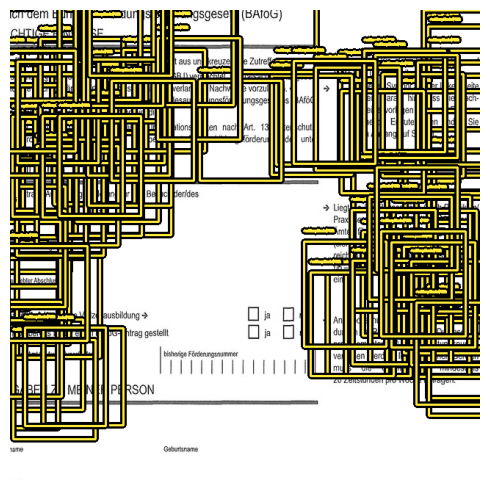

In [95]:
def visualize_detections(model, dataset, bounding_box_format):
    # for i in range(10):
    images, y_true = next(iter(dataset.take(3)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    print(y_pred['boxes'])
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        # y_true=y_true,
        y_pred=y_pred,
        scale=5,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.1,
        class_mapping=class_mapping,
    )
visualize_detections(yolo, dataset=train_ds, bounding_box_format="xyxy")